# Ultimate Technologies, Inc. Interview Challenge, Part 3: Predictive Modeling

<div class="alert alert-block alert-info">
<b>NOTE:</b> This is for part 3 ONLY of a 3-part project. Parts 1 and 2 are contained in a separate notebook.
</div>

---

## Table of Contents

* [Introduction](#intro)
    * [Import relevant packages](#import)
* [Prompt 1: Data Cleaning, EDA, and Visualization](#p1)
    * [PROMPT 1 ANSWER](#p1-answer)
    * [Data cleaning](#data-cleaning)
    * [Exploratory data analysis](#eda)
    * [Visualizations](#visualizations)
* [Prompt 2: Predictive model](#p2)
    * [PROMPT 2 ANSWER](#p2-answer)
* [Prompt 3: Model insights](#p3)
    * [PROMPT 3 ANSWER](#p3-answer)

---

## Introduction <a name="intro"></a>

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. 

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

<div class="alert alert-block alert-info">
<b>Note:</b> See blue boxes below for answers to these questions, or see Table of Contents for shortcuts.
</div>

### Data description <a name="data-description"></a>

- `city`: city this user signed up in
- `phone`: primary device for this user
- `signup_date`: date of account registration; in the form ‘YYYYMMDD’
- `last_trip_date`: the last time this user completed a trip; in the form ‘YYYYMMDD’
- `avg_dist`: the average distance in miles per trip taken in the first 30 days after signup
- `avg_rating_by_driver`: the rider’s average rating over all of their trips
- `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips
- `surge_pct`: the percent of trips taken with surge multiplier > 1
- `avg_surge`: The average surge multiplier over all of this user’s trips
- `trips_in_first_30_days`: the number of trips this user took in the first 30 days after signing up
- `ultimate_black_user`: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise
- `weekday_pct`: the percent of the user’s trips occurring during a weekday

### Import relevant packages <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import logistic

import warnings

---

# 1 - Data cleaning, EDA, and visualization <a name="p1"></a>

## Data cleaning <a name="data-cleaning"></a>

In [2]:
# Open and read the JSON file
with open('ultimate_data_challenge.json', 'r') as file:
    data = json.load(file)

In [3]:
# Check data type
type(data)

list

In [4]:
# Look at data
data

[{'city': "King's Landing",
  'trips_in_first_30_days': 4,
  'signup_date': '2014-01-25',
  'avg_rating_of_driver': 4.7,
  'avg_surge': 1.1,
  'last_trip_date': '2014-06-17',
  'phone': 'iPhone',
  'surge_pct': 15.4,
  'ultimate_black_user': True,
  'weekday_pct': 46.2,
  'avg_dist': 3.67,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 0,
  'signup_date': '2014-01-29',
  'avg_rating_of_driver': 5.0,
  'avg_surge': 1.0,
  'last_trip_date': '2014-05-05',
  'phone': 'Android',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 50.0,
  'avg_dist': 8.26,
  'avg_rating_by_driver': 5.0},
 {'city': 'Astapor',
  'trips_in_first_30_days': 3,
  'signup_date': '2014-01-06',
  'avg_rating_of_driver': 4.3,
  'avg_surge': 1.0,
  'last_trip_date': '2014-01-07',
  'phone': 'iPhone',
  'surge_pct': 0.0,
  'ultimate_black_user': False,
  'weekday_pct': 100.0,
  'avg_dist': 0.77,
  'avg_rating_by_driver': 5.0},
 {'city': "King's Landing",
  'trips_in_fir

In [5]:
# Convert data to a DataFrame
df = pd.DataFrame(data=data)

### Check DataFrame

In [6]:
# Check DataFrame
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [7]:
# Check DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [8]:
# Convert df['signup_date'] and df['last_trip_date'] to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [9]:
# Check DataFrame info again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

## Exploratory Data Analysis <a name="eda"></a>

In [10]:
# Check data timespan
print("Earliest signup:", df['signup_date'].min())
print("Latest last_trip:", df['last_trip_date'].max())

Earliest signup: 2014-01-01 00:00:00
Latest last_trip: 2014-07-01 00:00:00


In [11]:
# Calculate days since signup for last trip
df['days_since_signup'] = (df['last_trip_date'] - df['signup_date']).dt.days

# Define 6th month
df['active_in_sixth_month'] = (df['days_since_signup'] >= 150)

Since users who have been active within the "preceding 30 days" are considered "active," and since our data spans 6 months exactly, we will consider users who are active in the sixth month as "retained."

In [12]:
# Check percentage of user retention
pct_retained = (sum(df['active_in_sixth_month'])/df['active_in_sixth_month'].count())*100
pct_retained

25.428

## Prompt 1 Answer <a name="p1-answer"></a>

<div class="alert alert-block alert-info">
<b>Prompt 1:</b> Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
</div>

After reading the JSON file, I converted it to a DataFrame. Then, I checked the timespan of the dataframe and determined that it covered exactly 6 months. With this in mind, I created a Boolean column indicating `True` for users whose last trip took place at least 150 days after signup and `False` for those who had no logged activity after 150 days. From there, I calculated the percentage of users retained by summing the number of `True` values and dividing by the total number of values in the column. My result from this procedure was that **25.4% of observed users were retained.**

---

# 2 - Predictive model <a name="p2"></a>

Let's visualize the relationship between some key features and retention in our data. Visualizing these relationships will help us determine which model would be most appropriate to use. Specifically, we are looking for whether these relationships are linear or non-linear.

Key features we will look at include the following:
- `trips_in_first_30_days`: Early usage patterns could predict user retention.
- `avg_dist`: User retention could vary depending on whether users take short trips or long trips.
- `surge_pct`: This percentage indicates whether users are willing to pay premium prices in order to use the service.
- `weekday_pct`: Could indicate whether users are using the service for commuting to work or for weekend recreation.

## Visualization

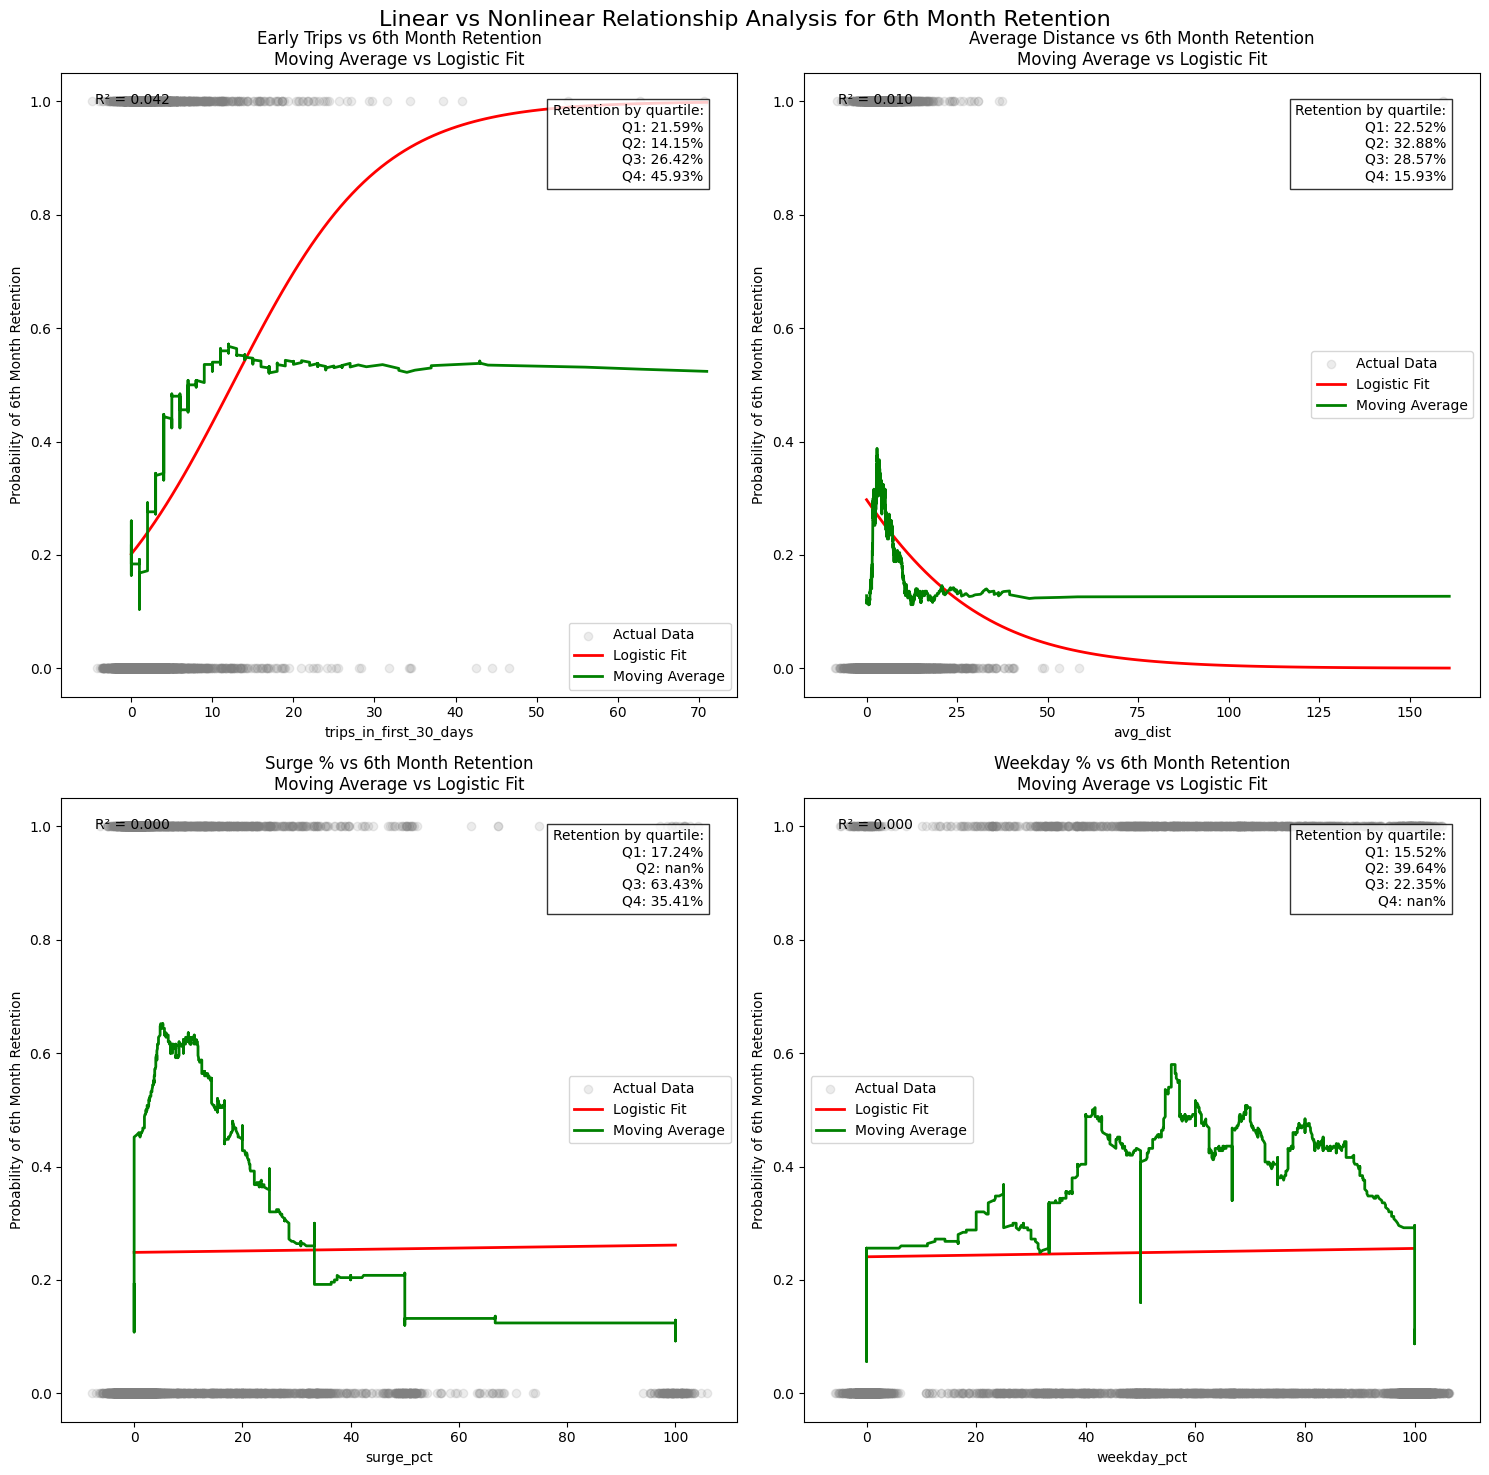

In [13]:
# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Create plots comparing linear and nonlinear fits
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Linear vs Nonlinear Relationship Analysis for 6th Month Retention', fontsize=16)

features = ['trips_in_first_30_days', 'avg_dist', 'surge_pct', 'weekday_pct']
titles = ['Early Trips vs 6th Month Retention', 
          'Average Distance vs 6th Month Retention',
          'Surge % vs 6th Month Retention', 
          'Weekday % vs 6th Month Retention']

for idx, (feature, title) in enumerate(zip(features, titles)):
    row = idx // 2
    col = idx % 2
    
    # Sample data for better visualization
    sample_size = min(5000, len(df))  # Increased sample size for better representation
    sample_df = df.sample(n=sample_size, random_state=42)
    
    # Prepare X and y
    X = sample_df[feature].values.reshape(-1, 1)
    y = sample_df['active_in_sixth_month'].values
    
    # Fit logistic regression
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    log_reg = LogisticRegression()
    log_reg.fit(X_scaled, y)
    
    # Create feature range for predictions
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    X_range_scaled = scaler.transform(X_range)
    
    # Get predictions
    y_pred = log_reg.predict_proba(X_range_scaled)[:, 1]
    
    # Plot actual data points with jitter
    jitter_amount = (X.max() - X.min()) * 0.02
    axes[row, col].scatter(X + np.random.normal(0, jitter_amount, X.shape), y, 
                          alpha=0.15, label='Actual Data', color='gray')
    
    # Plot logistic regression line
    axes[row, col].plot(X_range, y_pred, 'r-', 
                       label='Logistic Fit', linewidth=2)
    
    # Calculate and plot moving average
    # Sort the data by feature value
    sorted_indices = np.argsort(X.flatten())
    X_sorted = X[sorted_indices].flatten()
    y_sorted = y[sorted_indices]
    
    # Adaptive window size based on data density
    window_size = len(X_sorted) // 20  # 5% of data points
    
    # Calculate moving average
    moving_avg = pd.Series(y_sorted).rolling(
        window=window_size, center=True, min_periods=1).mean()
    
    axes[row, col].plot(X_sorted, moving_avg, 'g-', 
                       label='Moving Average', linewidth=2)
    
    # Customize plot
    axes[row, col].set_title(f'{title}\nMoving Average vs Logistic Fit')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Probability of 6th Month Retention')
    axes[row, col].legend()
    
    # Calculate and display R-squared
    from sklearn.metrics import r2_score
    r2 = r2_score(y, log_reg.predict_proba(X_scaled)[:, 1])
    axes[row, col].text(0.05, 0.95, f'R² = {r2:.3f}', 
                       transform=axes[row, col].transAxes)
    
    # Add retention rate statistics
    percentiles = np.percentile(sample_df[feature], [25, 50, 75])
    retention_rates = [
        sample_df[sample_df[feature] <= percentiles[0]]['active_in_sixth_month'].mean(),
        sample_df[(sample_df[feature] > percentiles[0]) & 
                 (sample_df[feature] <= percentiles[1])]['active_in_sixth_month'].mean(),
        sample_df[(sample_df[feature] > percentiles[1]) & 
                 (sample_df[feature] <= percentiles[2])]['active_in_sixth_month'].mean(),
        sample_df[sample_df[feature] > percentiles[2]]['active_in_sixth_month'].mean()
    ]
    
    stats_text = f'Retention by quartile:\nQ1: {retention_rates[0]:.2%}\n' + \
                 f'Q2: {retention_rates[1]:.2%}\nQ3: {retention_rates[2]:.2%}\n' + \
                 f'Q4: {retention_rates[3]:.2%}'
    axes[row, col].text(0.95, 0.95, stats_text, 
                       transform=axes[row, col].transAxes,
                       verticalalignment='top',
                       horizontalalignment='right',
                       bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

The green line represents the trend in our data. The non-linear relationships of these graphs strongly support the use of a model like Random Forest Regression, which captures non-linear patterns better than linear ones.

Before implementing this model, we will take a closer look at some statistical features of these relationships. In conjunction with the graphs we created above, we will use this statistical analysis to assess whether our data requires feature engineering.

In [14]:
# Print statistical analysis
print("Statistical Analysis of Relationships with 6th Month Retention:")
for feature in features:
    quartiles = pd.qcut(df[feature], q=4, duplicates='drop')
    mean_retention = df.groupby(quartiles)['active_in_sixth_month'].agg(['mean', 'count'])
    print(f"\n{feature}:")
    print("Mean retention rate by feature quartiles:")
    print(mean_retention)
    
    # Test for monotonicity
    is_monotonic = mean_retention['mean'].is_monotonic_increasing or \
                  mean_retention['mean'].is_monotonic_decreasing
    print(f"Relationship is monotonic: {is_monotonic}")

Statistical Analysis of Relationships with 6th Month Retention:

trips_in_first_30_days:
Mean retention rate by feature quartiles:
                            mean  count
trips_in_first_30_days                 
(-0.001, 1.0]           0.189911  29498
(1.0, 3.0]              0.261215  11190
(3.0, 125.0]            0.449850   9312
Relationship is monotonic: True

avg_dist:
Mean retention rate by feature quartiles:
                    mean  count
avg_dist                       
(-0.001, 2.42]  0.223224  12530
(2.42, 3.88]    0.329139  12478
(3.88, 6.94]    0.290480  12500
(6.94, 160.96]  0.174432  12492
Relationship is monotonic: False

surge_pct:
Mean retention rate by feature quartiles:
                   mean  count
surge_pct                     
(-0.001, 8.6]  0.213781  37515
(8.6, 100.0]   0.375971  12485
Relationship is monotonic: True

weekday_pct:
Mean retention rate by feature quartiles:
                    mean  count
weekday_pct                    
(-0.001, 33.3]  0.164928  131

## Feature engineering

Observations for feature engineering:
- `trips_in_first_30_days` can be divided into 4 meaningful categories: 1. riders who took 0 trips, 2. riders who took 1 trip, 3. riders who took 2-3 trips, and 4. riders who took 4 or more trips.
- Out of four quartiles identified, riders who took trips between 2.42 and 3.88 miles had the highest retention rate, so we can define this as our "optimal" distance for `avg_dist`. We can also use our quartiles to create categories: `'short'` (trips under 2.42 miles), `'optimal'`, `'medium'`, (trips 3.88 to 6.94 miles), and `'long'` (trips over 6.94 miles).
- `surge_pct` shows a natural split between low-surge and high-surge users. We will add a boolean feature, `high_surge`, which will indicate whether a rider belongs to the "high-surge" category.
- `weekday_pct` has natural breaks at 33.3% and 66.6%. We can split riders between three categories: weekend-heavy users (those whose weekday-percentage usage is less than or equal to 33.3%), balanced users (between 33.3% and 66.6%), and weekday-heavy users (over 66.6%).

In [15]:
# Create a copy of our dataframe before implementing feature engineering
fe_df = df.copy()

In [16]:
# Let's identify our numeric and categorical columns
numeric_columns = ['trips_in_first_30_days', 'avg_dist', 'surge_pct', 
                  'weekday_pct', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                  'avg_surge']

categorical_columns = ['phone', 'city']

In [17]:
# PART 1
# Create trip categories
fe_df['trip_category'] = pd.cut(fe_df['trips_in_first_30_days'], 
                               bins=[-np.inf, 0, 1, 3, np.inf],
                               labels=['0_trips', '1_trip', '2_3_trips', '4_plus_trips'])

In [18]:
# PART 2
# Crate optimal distance range flag (peak retention was in 2.42-3.88 range)
fe_df['optimal_distance_range'] = ((fe_df['avg_dist'] >= 2.42) & fe_df['avg_dist'] <= 3.88)

# Distance categories based on retention patterns
fe_df['distance_category'] = pd.cut(fe_df['avg_dist'],
                                   bins=[-np.inf, 2.42, 3.88, 6.94, np.inf],
                                   labels=['short', 'optimal', 'medium', 'long'])

In [19]:
# PART 3
# Surge percent feature engineering
fe_df['high_surge'] = fe_df['surge_pct'] > 8.6

In [20]:
# PART 4
# Weekday percentage engineering
fe_df['balanced_usage'] = ((fe_df['weekday_pct'] >= 33.3) & (fe_df['weekday_pct'] <= 66.7))
fe_df['usage_pattern'] = pd.cut(fe_df['weekday_pct'],
                                bins=[-np.inf, 33.3, 66.7, np.inf],
                                labels=['weekend_heavy', 'balanced', 'weekday_heavy'])

In [21]:
# Add engineered categories to categorical columns list
categorical_columns += ['distance_category', 'usage_pattern', 'trip_category']

In [22]:
# Create dummy variables for categorical columns
fe_df = pd.get_dummies(fe_df, columns=categorical_columns, drop_first=True)

In [23]:
# Convert boolean columns to int
fe_df['high_surge'] = fe_df['high_surge'].astype(int)
if 'ultimate_black_user' in fe_df.columns:
    fe_df['ultimate_black_user'] = fe_df['ultimate_black_user'].astype(int)

## Model building
As we have previously mentioned, our features display non-linear relationships with user retention. Therefore, we will need to use a model that captures non-linear relationships well.

We will consider the following models, and then compare their performance:
1. Random Forest Regression
2. XGBoost

### Split training and testing data

In [24]:
# Only include numeric and dummy columns, explicitly exclude date columns and target
feature_columns = numeric_columns + [col for col in fe_df.columns 
                                   if col.startswith(tuple([f"{c}_" for c in categorical_columns])) 
                                   or col in ['high_surge', 'ultimate_black_user']]

In [25]:
# Remove any date columns or target column if they got included
feature_columns = [col for col in feature_columns 
                  if col not in ['active_in_sixth_month', 'signup_date', 'last_trip_date']]

In [26]:
X = fe_df[feature_columns]
y = fe_df['active_in_sixth_month']

In [27]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Since we will be comparing the results of each model, we will store them in a dictionary.

In [28]:
# Create dictionary to store model results
model_results = {}

### 1. Random Forest Regression

In [29]:
# Create and train RF model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42
)

In [30]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, random_state=42)

In [31]:
# Make predictions
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

In [32]:
# Store Random Forest results
rf_results = {
    'model': rf_model,
    'predictions': rf_predictions,
    'probabilities': rf_probabilities,
    'classification_report': classification_report(y_test, rf_predictions),
    'roc_auc': roc_auc_score(y_test, rf_probabilities)
}

#### Random Forest Model Performance

In [33]:
# Print Random Forest performance metrics
print("\nRandom Forest Model Performance:")
print("\nClassification Report:")
print(rf_results['classification_report'])
print(f"\nROC AUC Score: {rf_results['roc_auc']:.3f}")


Random Forest Model Performance:

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.77      0.83      7457
        True       0.52      0.73      0.61      2543

    accuracy                           0.76     10000
   macro avg       0.71      0.75      0.72     10000
weighted avg       0.80      0.76      0.77     10000


ROC AUC Score: 0.824


#### Random Forest Feature Importance Plot

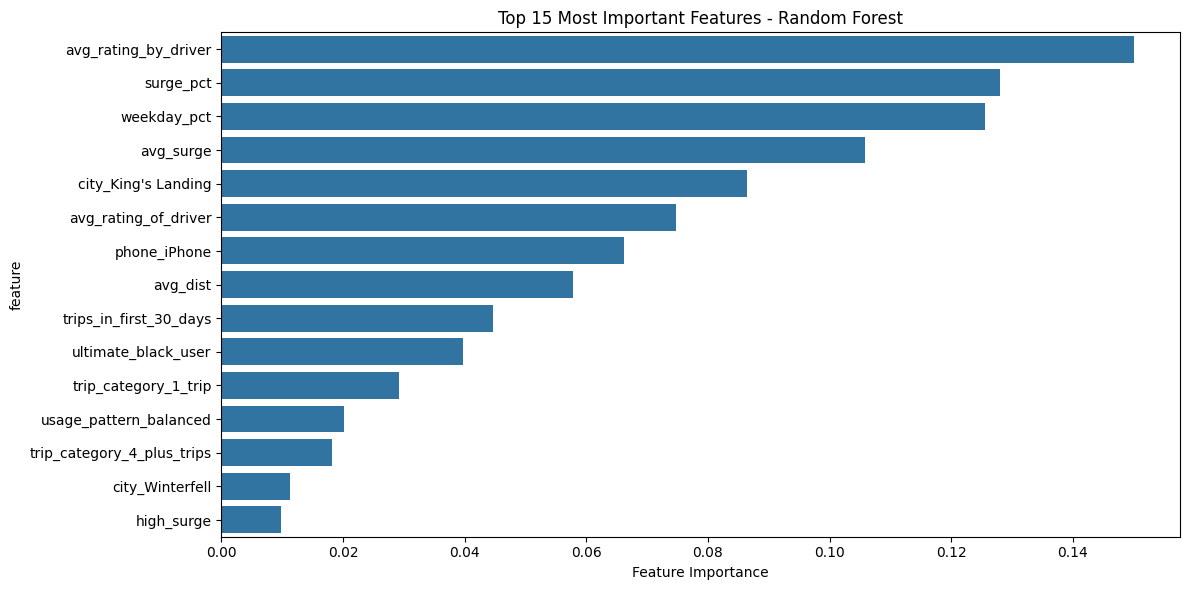

In [34]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features - Random Forest')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

#### Random Forest Confusion Matrix

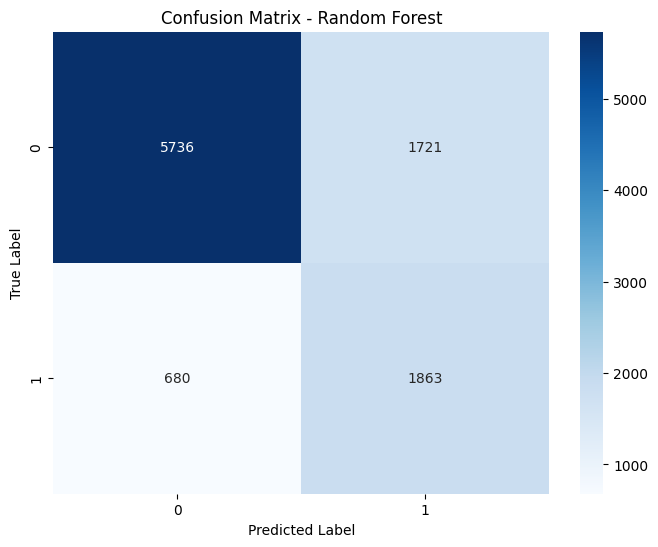

In [35]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### 2. XGBoost

In [36]:
# Calculate scale_pos_weight for imbalanced data
scale_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

In [37]:
# Create and train XGBoost model
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_weight,  # Handle class imbalance
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [38]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [39]:
# Make predictions
xgb_predictions = xgb_model.predict(X_test)
xgb_probabilities = xgb_model.predict_proba(X_test)[:, 1]

In [40]:
# Store XGBoost results
xgb_results = {
    'model': xgb_model,
    'predictions': xgb_predictions,
    'probabilities': xgb_probabilities,
    'classification_report': classification_report(y_test, xgb_predictions),
    'roc_auc': roc_auc_score(y_test, xgb_probabilities)
}

#### XGBoost Model Performance

In [41]:
# Print XGBoost performance metrics
print("\nXGBoost Model Performance:")
print("\nClassification Report:")
print(xgb_results['classification_report'])
print(f"\nROC AUC Score: {xgb_results['roc_auc']:.3f}")


XGBoost Model Performance:

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.75      0.82      7457
        True       0.51      0.76      0.61      2543

    accuracy                           0.75     10000
   macro avg       0.70      0.75      0.71     10000
weighted avg       0.80      0.75      0.77     10000


ROC AUC Score: 0.829


#### XGBoost Feature Importance Plot

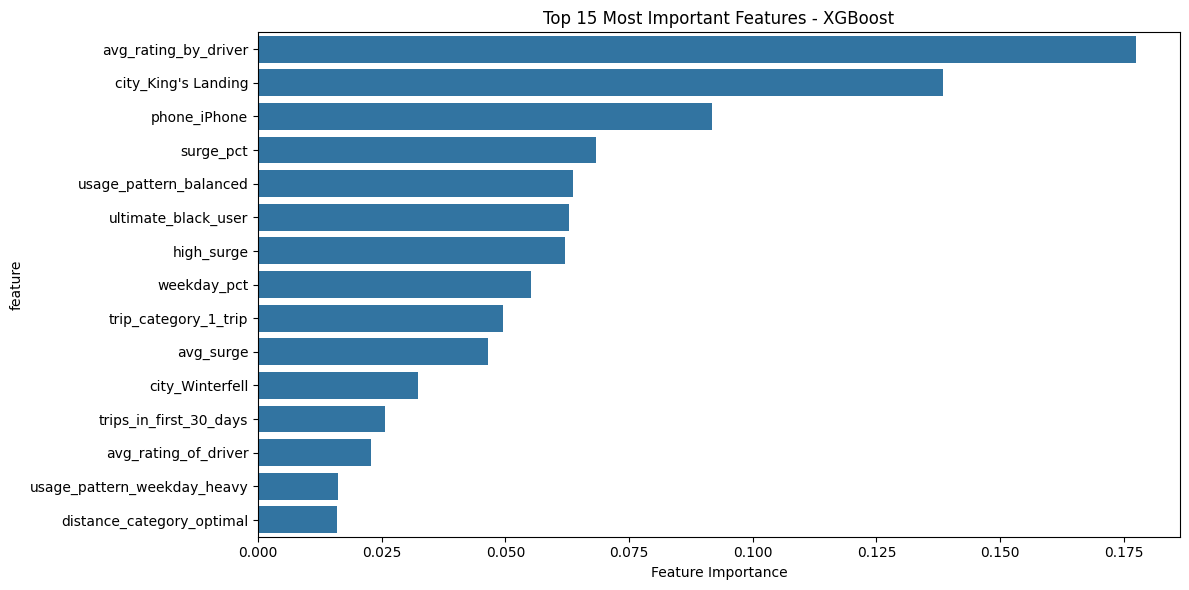

In [42]:
feature_importance_xgb = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
})
feature_importance_xgb = feature_importance_xgb.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_xgb.head(15))
plt.title('Top 15 Most Important Features - XGBoost')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

#### XGBoost Confusion Matrix

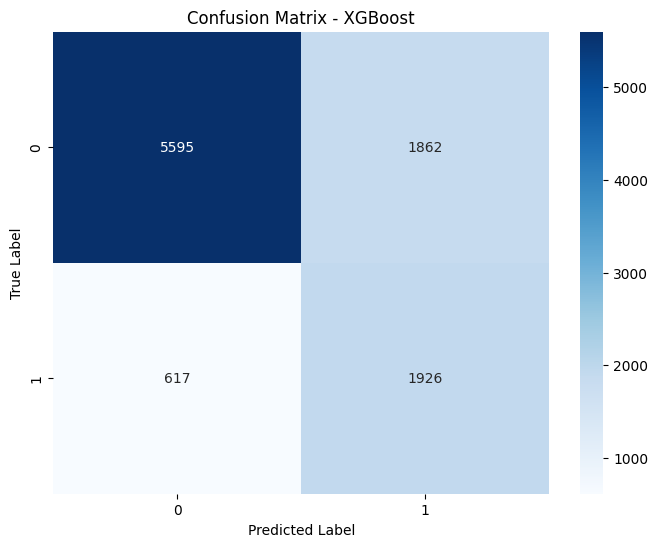

In [43]:
plt.figure(figsize=(8, 6))
cm_xgb = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Model Comparison

In [45]:
# Create comparison of classification reports
print("\nModel Performance Comparison:")
print("\nRandom Forest Classification Report:")
print(rf_results['classification_report'])
print("\nXGBoost Classification Report:")
print(xgb_results['classification_report'])


Model Performance Comparison:

Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.77      0.83      7457
        True       0.52      0.73      0.61      2543

    accuracy                           0.76     10000
   macro avg       0.71      0.75      0.72     10000
weighted avg       0.80      0.76      0.77     10000


XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.75      0.82      7457
        True       0.51      0.76      0.61      2543

    accuracy                           0.75     10000
   macro avg       0.70      0.75      0.71     10000
weighted avg       0.80      0.75      0.77     10000



Random Forest:
- False (Not Retained):
>Precision: 0.89<br>
Recall: 0.77
- True (Retained):
>Precision: 0.52<br>
Recall: 0.73

XGBoost:
- False (Not Retained):
>Precision: 0.90<br>
Recall: 0.75
- True (Retained):
>Precision: 0.51<br>
Recall: 0.76

- Both models are better at identifying non-retained users (False class)
- XGBoost has slightly better precision for non-retained users (0.90 vs 0.89)
- XGBoost has slightly better recall for retained users (0.76 vs 0.73)
- The models disagree on only 572 cases (388 + 184) out of 10,000
- Both models have similarly weighted F1-scores at 0.77.

#### ROC Curve Comparison

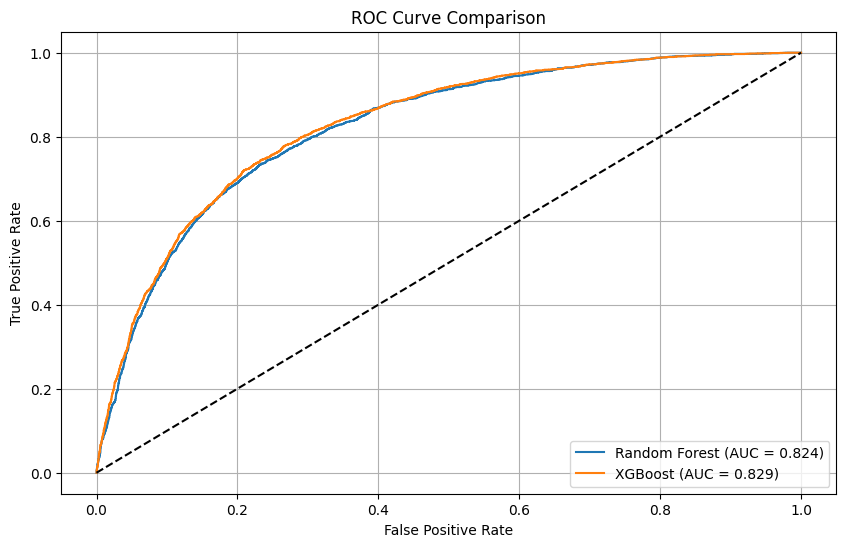

In [46]:
# ROC Curve Comparison
plt.figure(figsize=(10, 6))
# Random Forest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_results['probabilities'])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_results['probabilities'])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Both Random Forest and XGBoost perform similarly well; however, XGBoost's AUC of 0.829 slightly outperforms Random Forest's AUC of 0.824.

#### Feature Importance Comparison

In [47]:
# Feature Importance Comparison
# Get top 15 features from each model
rf_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance_rf': rf_model.feature_importances_
})

xgb_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance_xgb': xgb_model.feature_importances_
})

In [48]:
# Merge importance scores
feature_comparison = pd.merge(rf_importance, xgb_importance, on='feature')

In [49]:
# Get union of top 15 features from both models
top_features_rf = set(feature_comparison.nlargest(15, 'importance_rf')['feature'])
top_features_xgb = set(feature_comparison.nlargest(15, 'importance_xgb')['feature'])
top_features = list(top_features_rf.union(top_features_xgb))

In [50]:
# Filter for top features
plot_data = feature_comparison[feature_comparison['feature'].isin(top_features)]

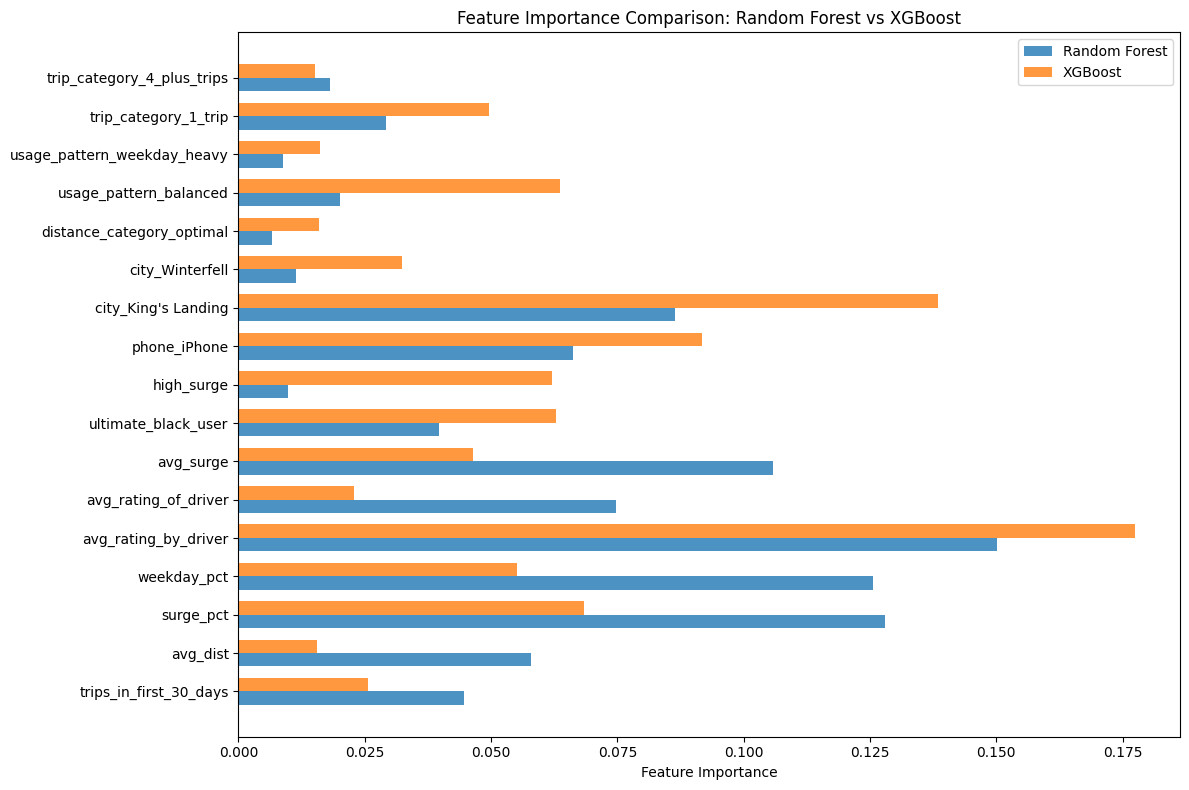

In [51]:
# Create comparison plot
plt.figure(figsize=(12, 8))
x = np.arange(len(top_features))
width = 0.35

plt.barh(x - width/2, plot_data['importance_rf'], width, label='Random Forest', alpha=0.8)
plt.barh(x + width/2, plot_data['importance_xgb'], width, label='XGBoost', alpha=0.8)

plt.yticks(x, plot_data['feature'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Comparison: Random Forest vs XGBoost')
plt.legend()
plt.tight_layout()
plt.show()

Both models generally agree on the most influential features, but each assigns slightly different weights to them.

#### Simplified Model Comparison

In [54]:
print("Simplified Model Comparison:")
print(f"Random Forest ROC AUC: {rf_results['roc_auc']:.3f}")
print(f"XGBoost ROC AUC: {xgb_results['roc_auc']:.3f}")

Simplified Model Comparison:
Random Forest ROC AUC: 0.824
XGBoost ROC AUC: 0.829


#### Prediction Agreement Matrix

In [58]:
# Prediction Agreement Analysis
agreement_matrix = pd.crosstab(
    rf_results['predictions'],
    xgb_results['predictions'],
    margins=True
)
print("Prediction Agreement Matrix:")
print(agreement_matrix)

# Calculate agreement percentage
agreement_pct = (
    (rf_results['predictions'] == xgb_results['predictions']).sum() 
    / len(rf_results['predictions']) * 100
)
print(f"\nModel Agreement Percentage: {agreement_pct:.2f}%")

Prediction Agreement Matrix:
col_0     0     1    All
row_0                   
False  6028   388   6416
True    184  3400   3584
All    6212  3788  10000

Model Agreement Percentage: 94.28%


- 388 cases: RF predicts False, XGB predicts True
- 184 cases: RF predicts True, XGB predicts False
<br><br>
- XGBoost tends to predict "retained" more often when they disagree

It is noteworthy that our model agreement percentage of 94.28% suggests there is high consistency between both models.

### Model Evaluation

While both models have similar performance, XGBoost demonstrated better performance in predicting retained users than did Random Forest. XGBoost correctly identified 76% of retained users, while Random Forest correctly identified 73%. Therefore, XGBoost does a better job at actually answering our business question of whether a user will be active or not in their sixth month on the system.

## Prompt 2 Answer <a name="p2-answer"></a>

<div class="alert alert-block alert-info">
<b>Prompt 2:</b> Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
</div>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;I developed and compared two different models &mdash; Random Forest and XGBoost &mdash; for capturing the non-linear relationships between our features and user retention. While I *did* consider creating a Logistic Regression as well, I ultimately decided against this as it would have required us to impute missing values in our training data at the expense of model performance. Meanwhile, Random Forest and XGBoost can handle missing values natively.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;While both models performed similarly well, I ultimately favored the XGBoost model as it demonstrated better performance in predicting retained users than did Random Forest. XGBoost correctly identified 76% of retained users, while Random Forest correctly identified 73%. Therefore, XGBoost does a better job at actually answering our business question of whether a user will be active or not in their sixth month on the system.<br><br>

---

# 3 - Model insights <a name="p3"></a>

## Prompt 3 Answer <a name="p3-answer"></a>

<div class="alert alert-block alert-info">
<b>Prompt 3:</b> Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).
</div>

Based on our XGBoost model's feature importance analysis, Ultimate should focus on maximizing early engagement within a user's first 30 days, as number of trips taken during this period is a strong predictor of long-term retention. The model also indicates that users with balanced weekday-weekend usage (between 33.3% and 66.7% weekday trips) and those taking trips within an optimal distance range (2.42-3.88 miles) show higher retention rates, suggesting Ultimate could create targeted promotions and incentives to encourage these specific usage patterns. Finally, given that surge pricing exposure affects retention, Ultimate might consider implementing a "new user protection" program that limits surge pricing during a user's first month to encourage establishing regular usage patterns.